In [107]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing

In [108]:
# Loading the MNIST datasets - 60000 images for training and 10000 images for testing
(imageTrainRaw, labelTrainRaw), (imageTestRaw, labelTestRaw) = tf.keras.datasets.mnist.load_data()

# Splitting the training set into 2: 55000 images for training and 5000 images for validation
imageTestRaw = imageTestRaw[:]
labelTestRaw = labelTestRaw[:]
sizeTest = 10000

imageValidRaw = imageTrainRaw[55000:]
labelValidRaw = labelTrainRaw[55000:]
sizeValid = 5000

imageTrainRaw = imageTrainRaw[:55000]
labelTrainRaw = labelTrainRaw[:55000]
sizeTrain = 55000

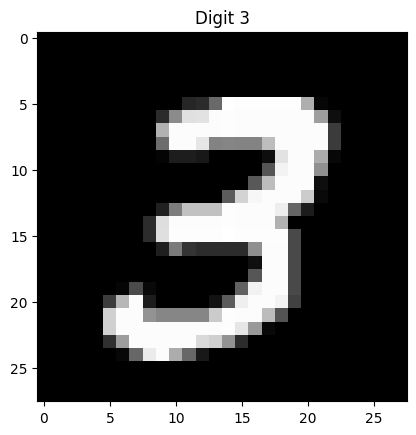

In [109]:
# Visualizing data
# Printing an array
def printArr(idx):
    to_write = ""
    for i in range(28):
        for j in range(28):
            if(len(str(imageTrainRaw[idx][i][j])) == 1):
                to_write += str(imageTrainRaw[idx][i][j]) + "    "
            elif(len(str(imageTrainRaw[idx][i][j])) == 2):
                to_write += str(imageTrainRaw[idx][i][j]) + "   "
            else:
                to_write += str(imageTrainRaw[idx][i][j]) + "  "
        to_write += "\n"
    to_write += f"\nDigit: {labelTrainRaw[idx]}"
    with open("./test/imageArr.txt", "w") as file:
        file.write(to_write)
        
# Plotting an image
def plotImage(idx):
    pyplot.title(f"Digit {labelTrainRaw[idx]}")
    pyplot.imshow(imageTrainRaw[idx], cmap='gray')
    pyplot.savefig("./test/digitGrey.jpg")

idx = 7
printArr(idx)
plotImage(idx)

In [110]:
# Preprocessing data (normalizing image arrays and 1-hot encoding label arrays)
imageTest = imageTestRaw / 255
labelTest = tf.keras.utils.to_categorical(labelTestRaw, num_classes=10)

imageValid = imageValidRaw / 255
labelValid = tf.keras.utils.to_categorical(labelValidRaw, num_classes=10)

imageTrain = imageTrainRaw / 255
labelTrain = tf.keras.utils.to_categorical(labelTrainRaw, num_classes=10)

In [111]:
# Setting up the neural network layer dimension and hypermeters 
batchSize = 1       # Batch size to perform GD
iter = 20000        # Number of iterations
eta = 0.05          # Initial learning rate
stride = 1          # Stride for convolution layer
padding = 0         # Padding for convolution layer
inputDim = 28       # Dimension of input layer = 28 x 28
kernelNum = 5       # Number of kernels (filters)
kernelDim = 3       # Dimension of kernel = 3 x 3
featureDim = 26     # Dimension of feature map = inputDim + 2 * padding - kernelDim) / stride + 1 
hiddenDim = 20     # Dimension of hidden layer = 20 x 20
outputDim = 10      # Dimension of output layer = 10 x 1
sizeTest = 10000    # Size of test set
sizeValid = 5000    # Size of validation set
sizeTrain = 55000   # Size of training set

In [121]:
def convolutionFF(x, k, batchSize):
    v = np.zeros((batchSize, 1, kernelNum * featureDim**2))
    for idx in range(batchSize):
        xTemp = x[idx]
        result = np.zeros((kernelNum, featureDim, featureDim))
        
        for n in range(kernelNum):
            for i in range(featureDim):
                for j in range(featureDim):
                    result[n, i, j] = np.sum(np.multiply(k[n], xTemp[i : i + kernelDim, j : j + kernelDim]))
        result = result.reshape(1, kernelNum * featureDim**2)
    return x

# def convolutionBP(self, x, kernel):
#     result = np.zeros((1, self.kernelDim, self.kernelDim))
#     for n in range(1):
#         for i in range(self.kernelDim):
#             for j in range(self.kernelDim):
#                 result[n, i, j] = np.sum(np.multiply(kernel[n], x[i : i + self.featureDim, j : j + self.featureDim]))
#     return result.reshape(3, 3)

# ReLU activation for hidden layer
def relu(x):
    return np.maximum(0, x)

# Softmax activation for output layer
def softmax(x):
    c = np.max(x, axis = 0, keepdims=True)
    x -= c
    e = np.exp(x)
    return e / np.sum(e, axis = 0, keepdims=True)

# Calculating loss value using cross entropy
def flossCE(yCal, yLabel):
    result = -np.sum(np.log(yCal) * yLabel)
    return result

def train(batchSize, iter, eta, filename):
    # Initializing kernels, weights, biases and eta
    k =  0.01 * np.random.rand( kernelNum, kernelDim, kernelDim)
    w1 = 0.01 * np.random.rand(kernelNum * featureDim**2, hiddenDim**2)
    b1 = 0.01 * np.random.rand(hiddenDim**2, batchSize)
    w2 = 0.01 * np.random.rand(hiddenDim**2, outputDim)
    b2 = 0.01 * np.random.rand(outputDim, batchSize)

    lossList = []
    lossPrev = 100000
    to_write = ""
    
    for n in range(iter + 1):
        idxList = np.random.randint(0, sizeTrain, size=batchSize)
        lossTotal = 0
        for idx in idxList:
            # Feedforward
            x = imageTrain[idx].T
            v = convolutionFF(x, k).reshape(kernelNum * featureDim**2, batchSize)
            z1 = np.dot(w1.T, v) + b1
            a1 = relu(z1)
            z2 = np.dot(w2.T, a1) + b2
            a2 = softmax(z2)
            
            yCal = a2 
            yLabel = labelTrain[idx].reshape(10, 1)
            loss = flossCE(yCal, yLabel)
            lossTotal += loss
            
            if(loss < lossPrev):
                lossPrev = loss
                kRes = k
                w1Res = w1
                b1Res = b1
                w2Res = w2
                b2Res = b2
                print(f"[Iter {n}] Loss: {loss}")
                to_write += f"[Iter {n}] Loss: {loss}\n"
                
            # Backpropagation
            e2 = (yCal - yLabel) / batchSize # gradient of softmax using cross entropy
            dw2 = np.dot(a1, e2.T)
            db2 = np.sum(e2, axis = 1, keepdims=True)
            e1 = np.dot(w2, e2)
            e1[z1 <= 0] = 0 # gradient of ReLU
            dw1 = np.dot(v, e1.T)
            db1 = np.sum(e1, axis = 1, keepdims=True)

            # Updating weights and biases
            w1 += -eta * dw1
            b1 += -eta * db1
            w2 += -eta * dw2
            b2 += -eta * db2
            
        if(n % 50 == 0):
            lossList.append(loss / batchSize)
    
    with open(f"./test/{filename}.txt", "w") as file:
        file.write(to_write)
        
    return (kRes, w1Res, b1Res, w2Res, b2Res, lossList)

def checkValid(kRes, w1Res, b1Res, w2Res, b2Res, batchSize):
    count = 0
    for idx in range(5000):
        if(idx % 100 == 0):
            print(f"Testing {idx}")
        x = imageValid[idx].T
        v = convolutionFF(x, kRes).reshape(kernelNum * featureDim**2, batchSize)
        z1 = np.dot(w1Res.T, v) + b1Res
        a1 = relu(z1)
        z2 = np.dot(w2Res.T, a1) + b2Res
        a2 = softmax(z2)
        yLabel = labelValid[idx].reshape(10, 1)
        prediction = np.argmax(a2)
        answer = np.argmax(yLabel)
        if(prediction == answer):
            count += 1
    return count / sizeValid


[Iter 0] Loss: 2.308707852873566
[Iter 5] Loss: 2.045117864296075
[Iter 11] Loss: 2.025841770829859
[Iter 22] Loss: 1.5474763599770602
[Iter 30] Loss: 1.3511543910664805
[Iter 49] Loss: 1.0196162900353212
[Iter 53] Loss: 1.003447904649049
[Iter 570] Loss: 0.9992061345354661
[Iter 586] Loss: 0.9285735330970858
[Iter 890] Loss: 0.7212551502038611
[Iter 1280] Loss: 0.6070712545098718
[Iter 1362] Loss: 0.33096039484600714
[Iter 1377] Loss: 0.29619161862066345
[Iter 1557] Loss: 0.21373693870131677
[Iter 1577] Loss: 0.14445673324790245
[Iter 1976] Loss: 0.08414620979728173
[Iter 2092] Loss: 0.07684701466971956
[Iter 2333] Loss: 0.06386270851106218
[Iter 2364] Loss: 0.04892113867723574
[Iter 2454] Loss: 0.0429819686978406
[Iter 2862] Loss: 0.03140721860720779
[Iter 2998] Loss: 0.029820849552979985
[Iter 3082] Loss: 0.023663686419740818
[Iter 3288] Loss: 0.01160199138416694
[Iter 3434] Loss: 0.008874382648174242
[Iter 3809] Loss: 0.006313738627785572
[Iter 4820] Loss: 0.0021057405946975374
[It

0.871


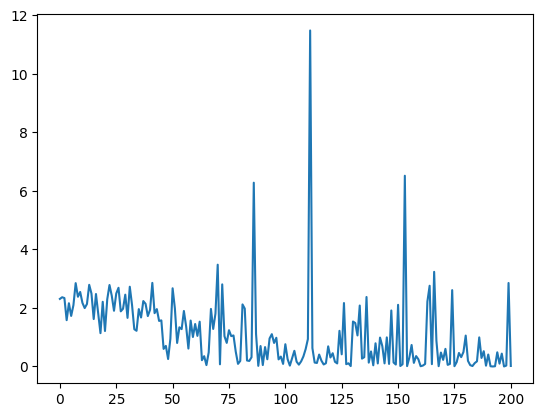

In [122]:
(mini_kRes, mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, miniLoss) = train(batchSize=1, iter=10000, eta=0.05, filename="miniLoss")
resultValid = checkValid(mini_kRes, mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, batchSize=1)
print(resultValid)
pyplot.plot(miniLoss)
# pyplot.plot(miniLoss2)
pyplot.show() 